In [19]:
# Import all libaries
import numpy
import json
import pandas as pd
import os as OS
import matplotlib.pyplot as plt
from skimage.io import imread
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import numpy as np

In [20]:
# Map directories
map_base_dir = 'input/'
map_img_dir = 'input/train/images/'

In [5]:
json_path = OS.path.join(map_base_dir, 'annotation.json')
with open(json_path,'r') as f:
    annot_data = json.load(f)

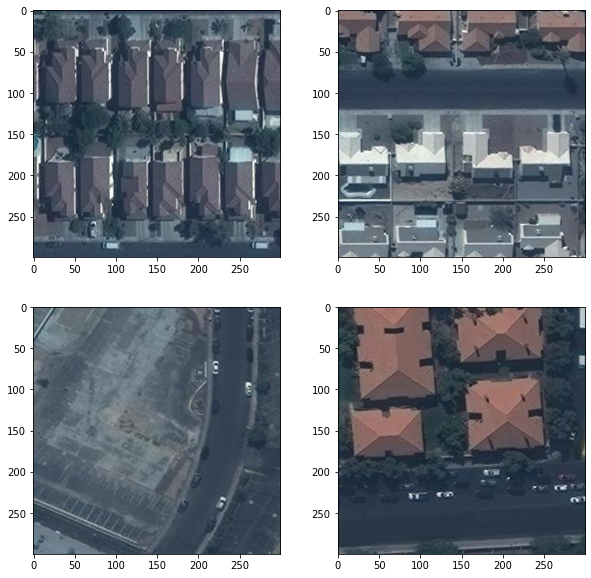

In [12]:
image_df = pd.DataFrame(annot_data['images'])
image_df.sample(3)
fig, m_axs = plt.subplots(2,2,figsize=(10,10))
for c_ax, (_, c_row) in zip(m_axs.flatten(), image_df.sample(4).iterrows()):
    img_data = imread(OS.path.join(map_img_dir, c_row['file_name']))
    c_ax.imshow(img_data)

In [13]:
annot_df = pd.DataFrame(annot_data['annotations'])
annot_df.sample(3)

,id,image_id,segmentation,area,bbox,category_id,iscrowd
2106944,1215138,142618,"[[59.0, 28.000000000000007, 1.0, 27.0000000000...",1595.0,"[1.0, 1.0, 58.0, 58.0]",100,0
357446,2046964,240164,"[[171.0, 214.0, 234.0, 214.0, 234.0, 247.0, 17...",2308.0,"[171.0, 162.0, 77.0, 72.0]",100,0
1393134,335009,39251,"[[173.0, 55.0, 163.0, 65.0, 171.0, 79.0, 122.0...",2687.0,"[55.0, 103.0, 118.0, 70.0]",100,0


In [14]:
full_df = pd.merge(annot_df, image_df, how='left', left_on = 'image_id', right_on='id').dropna()
print(image_df.shape[0], '+', annot_df.shape[0], '->', full_df.shape[0])
full_df.sample(2)

280741 + 2395553 -> 2395553


,id_x,image_id,segmentation,area,bbox,category_id,iscrowd,id_y,file_name,width,height
373546,847732,99414,"[[240, 175, 240, 178, 263, 178, 263, 201, 238,...",2031.0,"[175, 188, 88, 75]",100,0,99414,000000099414.jpg,300,300
2085276,398905,46803,"[[265, 50, 295, 50, 295, 70, 300, 70, 300, 122...",2500.0,"[50, 257, 250, 43]",100,0,46803,000000046803.jpg,300,300


In [16]:
def create_boxes(in_rows):
    box_list = []
    for _, in_row in in_rows.iterrows():
        # bbox -> coco std.
        (start_y, start_x, wid_y,wid_x) = in_row['bbox']
        box_list += [Rectangle((start_x,start_y), wid_y, wid_x)]
    return box_list

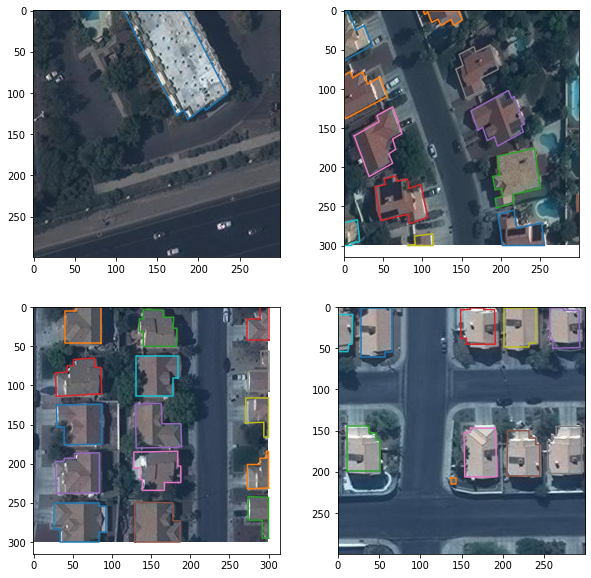

In [21]:
fig, m_axs = plt.subplots(2, 2, figsize = (10,10))
for c_ax, (c_id, c_df) in zip (m_axs.flatten(), full_df.groupby('image_id')):
    img_data = imread(OS.path.join(map_img_dir, c_df['file_name'].values[0]))
    c_ax.imshow(img_data)
    #c_ax.add_collection(PatchCollection(create_boxes(c_df), alpha = 0.25, facecolor = 'red'))
    for _, c_row in c_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label = c_df['id_x'])

In [22]:
from matplotlib.path import Path
from skimage.color import label2rgb
def rows_to_segmentation(in_img, in_df):
    xx, yy = np.meshgrid(range(in_img.shape[0]), 
                range(in_img.shape[1]),
               indexing='ij')
    out_img = np.zeros(in_img.shape[:2])
    for _, c_row in in_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label = c_df['id_x'])
        xy_path = Path(xy_vec)
        out_img += xy_path.contains_points(np.stack([yy.ravel(), 
                                                     xx.ravel()], -1)).reshape(out_img.shape)
    return out_img

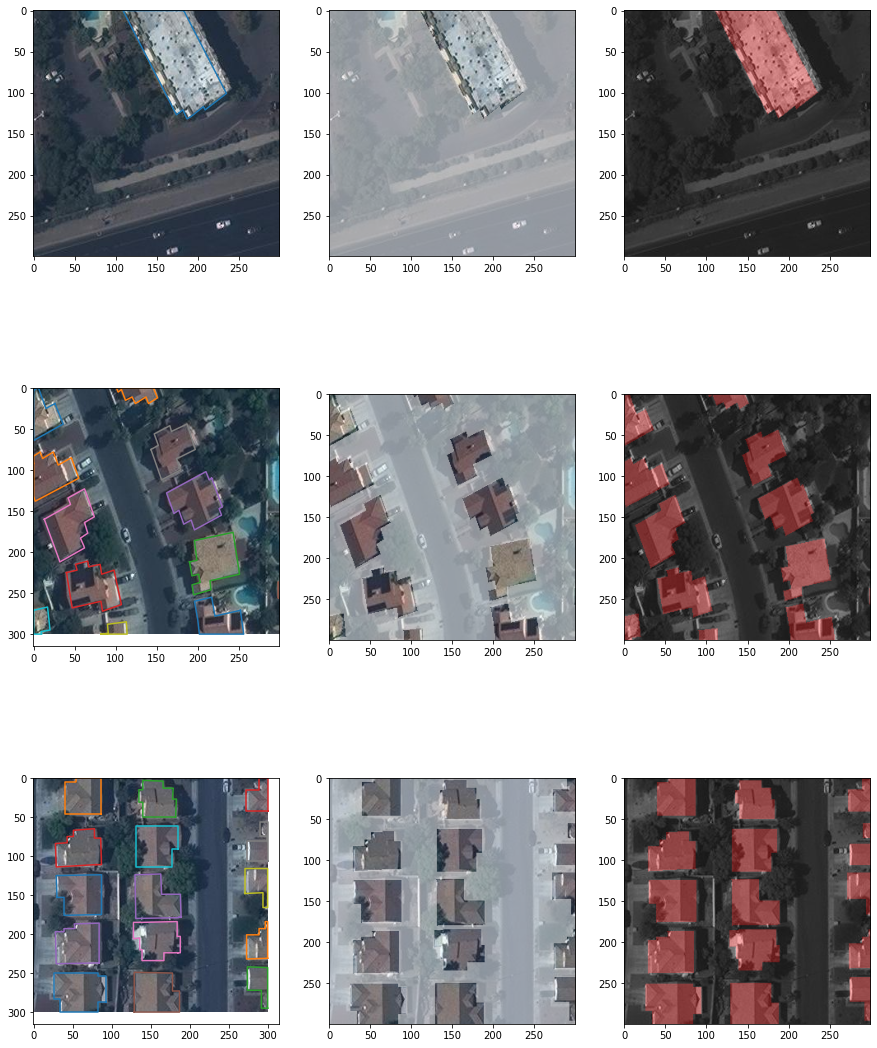

In [24]:
fig, m_axs = plt.subplots(3, 3, figsize = (15, 20))
for (c_ax, d_ax, f_ax), (c_id, c_df) in zip(m_axs,
                                      full_df.groupby('image_id')):
    img_data = imread(OS.path.join(map_img_dir, c_df['file_name'].values[0]))
    c_ax.imshow(img_data)
    out_img = rows_to_segmentation(img_data, c_df)
    rgba_img = np.concatenate([img_data, 
                               np.clip(np.expand_dims(127*out_img+127, -1), 0, 255).astype(np.uint8)
                              ], -1)
    d_ax.imshow(rgba_img)
    
    f_ax.imshow(label2rgb(image=img_data, label=out_img, bg_label = 0))

In [25]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(image_df['id'], test_size = 0.25)
train_df = full_df[full_df['image_id'].isin(train_ids)]
valid_df = full_df[full_df['image_id'].isin(valid_ids)]
print(train_df.shape[0], 'training boxes')
print(valid_df.shape[0], 'validation boxes')

ModuleNotFoundError: No module named 'sklearn'